In [1]:
import torch

def transform_tensor(X, weights):
    # X is a 4D tensor of shape (a, b, c, d)
    # weights is a 1D tensor of shape (2,)
    
    a, b, c, d = X.shape
    # 스택하고 리쉐이프하는 과정
    X_stacked = X.permute(1, 2, 0, 3).reshape(b, c, a * d)
    
    # 새로운 텐서를 생성하는데, 마지막 차원을 계산에 이용
    new_last_dim = []
    for i in range(0, a * d, 2):  # 2개씩 짝을 지어 처리
        # 인접한 값들을 가중 평균
        weighted_avg = (weights[0] * X_stacked[:, :, i] + weights[1] * X_stacked[:, :, i+1]) / weights.sum()
        new_last_dim.append(weighted_avg)
    
    # 새로운 마지막 차원을 스택
    new_tensor = torch.stack(new_last_dim, dim=-1)
    return new_tensor

# 예시 텐서
X = torch.tensor([[[[1, 2], [3, 4]], [[1, 2], [3, 4]]], [[[5, 6], [7, 8]], [[5, 6], [7, 8]]]])
weights = torch.tensor([1, 2])

In [12]:
X

tensor([[[[1, 2],
          [3, 4]],

         [[1, 2],
          [3, 4]]],


        [[[5, 6],
          [7, 8]],

         [[5, 6],
          [7, 8]]]])

In [18]:
X_stacked = X.permute(1, 2, 0, 3).reshape(2, 2, 4)
X_stacked

tensor([[[1, 2, 5, 6],
         [3, 4, 7, 8]],

        [[1, 2, 5, 6],
         [3, 4, 7, 8]]])

In [25]:
# 부드럽게 Tensor 연결하는 함수 정의
def smoothing(X):
    # X is a 4D tensor of shape (a, b, c, d)
    # weights is a 1D tensor of shape (2,)
    
    a, b, c, d = X.shape
    # 스택하고 리쉐이프하는 과정
    X_stacked = X.permute(1, 2, 0, 3).reshape(b, c, a * d)
    
    # 2개씩 짝을 지어 처리
    for j in range(a-1):  
        ct_point = d*(j+1)

        ct_before = X_stacked[:, :, ct_point-1]
        ct_after = X_stacked[:, :, ct_point]
        for k in range(d//2):
            X_stacked[:, :, k + ct_point - d//2] = (d-k)/(d+1) * X_stacked[:, :, k + ct_point - d//2] + (k+1)/(d+1) * ct_after
        for k in range(d//2):
            X_stacked[:, :, k + ct_point ] = (d//2 + k +1)/(d+1) * X_stacked[:, :, k + ct_point ] + (d//2 - k)/(d+1) * ct_before
    
    return X_stacked

In [21]:
ct_point = 2
ct_before = X_stacked[:, :, ct_point-1]
ct_after = X_stacked[:, :, ct_point]
ct_before, ct_after

(tensor([[2, 4],
         [2, 4]]),
 tensor([[5, 7],
         [5, 7]]))

In [22]:
X_stacked[:, :,1] = 2/3 * X_stacked[:, :, 1] + 1/3 * ct_after

In [23]:
X_stacked[:, :,2] = 2/3 * X_stacked[:, :, 2] + 1/3 * ct_before

In [24]:
X_stacked

tensor([[[1, 3, 4, 6],
         [3, 5, 6, 8]],

        [[1, 3, 4, 6],
         [3, 5, 6, 8]]])

In [3]:
import numpy as np

vx = [np.array([1,2,3]), np.array([4,5,6])]
vx_mean = np.array([np.mean([vx[j][k] for j in range(len(vx))]) for k in range(len(vx[0]))])

In [4]:
vx_mean

array([2.5, 3.5, 4.5])

In [5]:
import torch
import torch.nn as nn

In [8]:
x_enc = torch.rand(8, 96, 21)
x_dec = torch.rand(8, 48, 21)

In [9]:
period_len=24
seg_num_x = 4
seg_num_y= 2
x_enc_list = [x_enc[:,j*period_len:(j+1)*period_len, :] for j in range(seg_num_x)] 
x_dec_list = [x_dec[:,j*period_len:(j+1)*period_len, :] for j in range(seg_num_y)]

In [11]:
lin_layer = nn.Linear(period_len, period_len)

In [13]:
_, _, N = x_enc.shape 

x_res1 = [] # 1단계 encoding
x_res = [[] for _ in range(seg_num_x)] # n단계 encoding
# 각 조각에 대해 조작
for k, x_enc_part in enumerate(x_enc_list + x_dec_list):
    if k< len(x_enc_list + x_dec_list)-1:
        x_enc_part = x_enc_part.permute(0,2,1)
        dec_part_out = lin_layer(x_enc_part).permute(0, 2, 1)[:, :, :N]
        x_res1.append(dec_part_out)

x_res[0] = x_res1

In [15]:
# x_res 채우기
for j in range(seg_num_x - 1):
    x_res_li = x_res[j]
    for k, x_enc_part in enumerate(x_res_li):
        if k< len(x_res_li)-1:
            x_enc_part = x_enc_part.permute(0,2,1)
            # Embedding
            #dec_out -> projection -> composition
            dec_part_out = lin_layer(x_enc_part).permute(0, 2, 1)[:, :, :N]
            x_res[j+1].append(dec_part_out)

In [17]:
print([len(x_res[k]) for k in range(len(x_res))])

[5, 4, 3, 2]


In [25]:
x_res[1]

[tensor([[[-0.1462, -0.1530, -0.1350,  ..., -0.2409, -0.0986, -0.0246],
          [ 0.3505,  0.5000,  0.1781,  ...,  0.1778,  0.5994,  0.3355],
          [ 0.5785,  0.5226,  0.4699,  ...,  0.5501,  0.5545,  0.4159],
          ...,
          [ 0.5235,  0.5994,  0.4568,  ...,  0.3220,  0.6158,  0.5555],
          [ 0.1779,  0.1689,  0.2323,  ...,  0.3444,  0.2225,  0.1650],
          [ 0.1068,  0.1562,  0.0980,  ..., -0.0362,  0.2959,  0.0929]],
 
         [[-0.0434, -0.1560, -0.1081,  ..., -0.2131, -0.2414, -0.2385],
          [ 0.4179,  0.2789,  0.3114,  ...,  0.4442,  0.5558,  0.2037],
          [ 0.5274,  0.4720,  0.4704,  ...,  0.4507,  0.5257,  0.4348],
          ...,
          [ 0.4334,  0.2842,  0.4016,  ...,  0.4790,  0.5210,  0.1819],
          [ 0.1896,  0.1997,  0.2520,  ...,  0.2103,  0.1489,  0.1618],
          [ 0.1386, -0.0969, -0.0132,  ...,  0.0819,  0.1185, -0.1572]],
 
         [[-0.2175, -0.0909, -0.3244,  ..., -0.2561, -0.2166, -0.1772],
          [ 0.4206,  0.5224,

In [28]:
x_dec_list[0]

tensor([[[0.6288, 0.5371, 0.5106,  ..., 0.2486, 0.5431, 0.7095],
         [0.0421, 0.5912, 0.5273,  ..., 0.9102, 0.8127, 0.6676],
         [0.1651, 0.6245, 0.8574,  ..., 0.6037, 0.6154, 0.6132],
         ...,
         [0.8225, 0.7479, 0.4148,  ..., 0.8168, 0.6929, 0.7590],
         [0.2444, 0.2481, 0.0571,  ..., 0.7084, 0.2329, 0.0626],
         [0.1952, 0.1329, 0.1572,  ..., 0.9014, 0.8685, 0.9232]],

        [[0.7423, 0.5223, 0.0066,  ..., 0.6509, 0.5387, 0.7467],
         [0.7524, 0.4213, 0.8008,  ..., 0.7234, 0.7156, 0.5028],
         [0.9406, 0.1087, 0.9521,  ..., 0.6577, 0.4510, 0.9789],
         ...,
         [0.8152, 0.2884, 0.8993,  ..., 0.4513, 0.7290, 0.2344],
         [0.6316, 0.4651, 0.3610,  ..., 0.6595, 0.6958, 0.3050],
         [0.1182, 0.7756, 0.6635,  ..., 0.2268, 0.6335, 0.7008]],

        [[0.2455, 0.9571, 0.5773,  ..., 0.8360, 0.3928, 0.6427],
         [0.4688, 0.7281, 0.8939,  ..., 0.3226, 0.9704, 0.4943],
         [0.1723, 0.2097, 0.7478,  ..., 0.4412, 0.6734, 0.

In [37]:
from sklearn.linear_model import LinearRegression

coef_col = []
lr = LinearRegression()
# Linear Regression 활용해서 보정.
for k in range(seg_num_y):
    X_stack = np.hstack([
        x_res[l][k + seg_num_x -1 - l].detach().numpy().reshape(-1, 1) for l in range(seg_num_x) 
    ])
    y = x_dec_list[k].detach().numpy().reshape(-1, 1)
    
    lr.fit(X_stack, y)

    coeff_vector = np.array(lr.coef_)[0]
    print(coeff_vector)
    coef_col.append(coeff_vector)

coeff_vector = np.array([np.mean([coef_col[j][k] for j in range(len(coef_col))]) for k in range(len(coef_col[0]))])

[ 0.01982198 -0.01166565  0.00781004  0.00367337]
[ 0.02516554 -0.0238343  -0.05208096  0.0305237 ]


In [38]:
coeff_vector

array([ 0.02249376, -0.01774998, -0.02213546,  0.01709853], dtype=float32)

In [50]:
dec_out_stack = []
for j in range(seg_num_y):
    dec_out_part = np.zeros(x_res[t][seg_num_x-1-t+j].detach().numpy().shape)
    for t in range(len(coeff_vector)):
        dec_out_part += coeff_vector[-t-1]*x_res[t][seg_num_x-1-t+j].detach().numpy()
    dec_out_stack.append(dec_out_part)
    
dec_out = np.concatenate(dec_out_stack, axis=1)

In [51]:
dec_out.shape

(8, 48, 21)

In [46]:
t = 0
j=0
np.zeros(x_res[t][seg_num_x-1-t+j].detach().numpy().shape).shape

(8, 24, 21)

In [1]:
# localhost - linear tensor test

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
%matplotlib inline

In [3]:
class LinearApproximation(nn.Module):
    def __init__(self, num_var):
        super(LinearApproximation, self).__init__()
        self.linear = nn.Linear(1, num_var, bias=True)
    
    def forward(self, t):
        return self.linear(t)
    

In [4]:
linear_approximation = LinearApproximation(8)


def train_linear_approximation(x_enc, num_epochs=1000, lr=0.001):
    B, T, N = x_enc.shape

    # time_step
    t = torch.arange(T) - (T) * torch.ones(T) # (-95,..., 0)
    t = t.float().unsqueeze(0).unsqueeze(-1) # (1, time, 1)
    t = t.repeat(B, 1, 1) # BATCH_SIZE, TIME_STEPs, 1

    optimizer = torch.optim.SGD(linear_approximation.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epochs in range(num_epochs):
        linear_approx_output = linear_approximation(t)
        loss = criterion(linear_approx_output, x_enc)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    a1 = linear_approximation.linear.weight.data
    a0 = linear_approximation.linear.bias.data

    return a0, a1

In [5]:
# data load
batch_path = './results/'
source = 'long_term_forecast_DiTransformer_Exchange_96_96_d01_noadj_DiTransformer_decomp_custom_ftM_sl96_ll48_pl96_dm512_nh8_el2_dl1_df2048_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0(1726646261)/'
pred_data = np.load(batch_path + source + 'pred.npy')
true_data = np.load(batch_path + source + 'true.npy')

In [6]:
pred_data.shape

(1422, 96, 8)

In [18]:
train_linear_approximation(torch.Tensor(true_data[:32, :, :]))

(tensor([ 0.2842,  0.1848,  0.6255,  1.1205,  0.3437, -0.4616,  0.3223,  0.3541]),
 tensor([[-0.0439],
         [ 0.0093],
         [-0.0235],
         [-0.0303],
         [-0.0088],
         [-0.0505],
         [-0.0482],
         [-0.0307]]))

In [19]:
train_linear_approximation(torch.Tensor(true_data[:32, :, :]))[0].shape, train_linear_approximation(torch.Tensor(true_data[:32, :, :]))[1].shape

(torch.Size([8]), torch.Size([8, 1]))

In [23]:
# 오류 부정
a0, a1 = train_linear_approximation(torch.Tensor(true_data[:32, :, :]))[0], train_linear_approximation(torch.Tensor(true_data[:32, :, :]))[1]

In [31]:
a00 = a0.unsqueeze(0).unsqueeze(1)
a00 = a00.repeat(32, 96, 1)

In [32]:
a00.shape

torch.Size([32, 96, 8])

In [33]:
a10 = a1.unsqueeze(0).permute(0,2,1)
a10 = a10.repeat(32, 96, 1)

torch.Size([32, 96, 8])

In [40]:
res0 = a00 + tp*a10
resa = res0.detach().cpu().numpy()

In [39]:
from utils.metrics import *

In [15]:
linear_approximation(torch.Tensor(true_data[:8, :, 0:1])).shape

torch.Size([8, 96, 8])

In [21]:
tp = t.repeat(1, 1, 8)

In [30]:
tp.shape

torch.Size([32, 96, 8])

In [8]:
B, T= 32, 96
t = torch.arange(T) - (T) * torch.ones(T) # (-95,..., 0)
t = t.float().unsqueeze(0).unsqueeze(-1) # (1, time, 1)
t = t.repeat(B, 1, 1) # BATCH_SIZE, TIME_STEPs, 1

In [20]:
t.shape

torch.Size([32, 96, 1])

In [9]:
optimizer = torch.optim.SGD(linear_approximation.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [10]:
linear_approx_output = linear_approximation(t)

In [11]:
true_data[:32, :, 0:1].shape

(32, 96, 1)

In [14]:
type(linear_approx_output)

torch.Tensor

In [41]:
MSE(resa, true_data[:32, :, :])

0.6335158

In [15]:
linear_approx_output.shape

torch.Size([32, 96, 8])

In [42]:
MSE(pred_data[:32, :, :], true_data[:32, :, :])

0.15286344

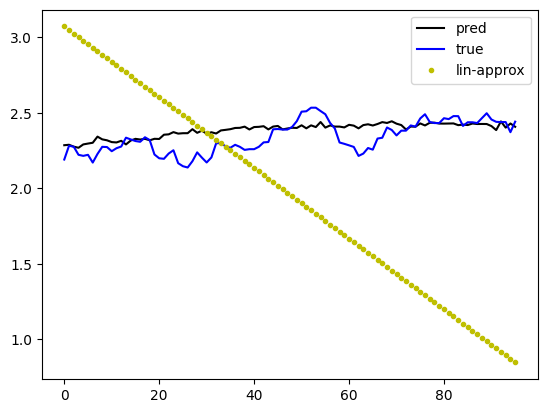

In [43]:
x0 = range(96)

idx = 0
plt.plot(x0, pred_data[idx, :, -1], 'k', label='pred')
plt.plot(x0, true_data[idx, :, -1], 'b', label='true')
plt.plot(x0, resa[idx, :, -1], 'y.', label='lin-approx')
plt.legend()
plt.show()

In [44]:
from sklearn.linear_model import LinearRegression

In [45]:
lr = LinearRegression()
X = np.array([[t] for t in range(96)])

In [46]:
idx = 0
val = -1
y = true_data[idx, :, -1]
reg = lr.fit(X, y)


In [47]:
rest = [reg.predict([[t]]) for t in range(96)]

In [49]:
rest0 = [val[0] for val in rest]

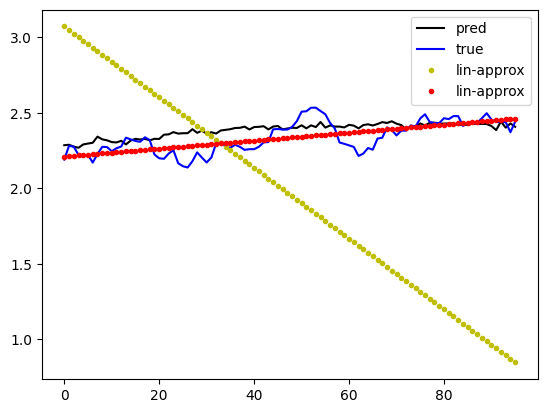

In [51]:
idx = 0
plt.plot(x0, pred_data[idx, :, -1], 'k', label='pred')
plt.plot(x0, true_data[idx, :, -1], 'b', label='true')
plt.plot(x0, resa[idx, :, -1], 'y.', label='lin-approx')
plt.plot(x0, rest0, 'r.', label='lin-approx')
plt.legend()
plt.show()

In [64]:
MAE(true_data[idx, :, -1], rest0), MAE(true_data[idx, :, -1], pred_data[idx, :, -1])

(0.05657014846388511, 0.07720589)

In [77]:
regs = [LinearRegression().fit(X, true_data[idx, :, k]) for k in range(8)]
rest = [[regs[k].predict([[t]])[0] for t in range(96)] for k in range(8)]

In [78]:
regs[0].predict([[4]]) - regs[-1].predict([[4]])

array([0.81551175])

In [79]:
regs[0].predict([[20]])

array([3.06424043])

In [80]:
rest = np.array(rest).T

In [59]:
rest

array([[2.21032748, 2.21032748, 2.21032748, 2.21032748, 2.21032748,
        2.21032748, 2.21032748, 2.21032748],
       [2.21297666, 2.21297666, 2.21297666, 2.21297666, 2.21297666,
        2.21297666, 2.21297666, 2.21297666],
       [2.21562584, 2.21562584, 2.21562584, 2.21562584, 2.21562584,
        2.21562584, 2.21562584, 2.21562584],
       [2.21827502, 2.21827502, 2.21827502, 2.21827502, 2.21827502,
        2.21827502, 2.21827502, 2.21827502],
       [2.2209242 , 2.2209242 , 2.2209242 , 2.2209242 , 2.2209242 ,
        2.2209242 , 2.2209242 , 2.2209242 ],
       [2.22357337, 2.22357337, 2.22357337, 2.22357337, 2.22357337,
        2.22357337, 2.22357337, 2.22357337],
       [2.22622255, 2.22622255, 2.22622255, 2.22622255, 2.22622255,
        2.22622255, 2.22622255, 2.22622255],
       [2.22887173, 2.22887173, 2.22887173, 2.22887173, 2.22887173,
        2.22887173, 2.22887173, 2.22887173],
       [2.23152091, 2.23152091, 2.23152091, 2.23152091, 2.23152091,
        2.23152091, 2.231520

In [81]:
MSE(rest, true_data[0, :, :]), MSE(pred_data[0, :, :], true_data[0, :, :])

(0.004882874547827559, 0.1411951)

In [82]:
[MAE(rest[:, k], true_data[0, :, k]) for k in range(8)]

[0.04481729920224709,
 0.06088898345493865,
 0.04816451492140078,
 0.08129575240108584,
 0.006447890096728613,
 0.08800224955668984,
 0.032979710206630646,
 0.05657014846388511]

In [83]:
[MAE(pred_data[0, :,k], true_data[0, :, k]) for k in range(8)]

[0.055344135,
 0.13963874,
 0.23333226,
 0.12147683,
 0.028011987,
 0.860792,
 0.10175135,
 0.07720589]

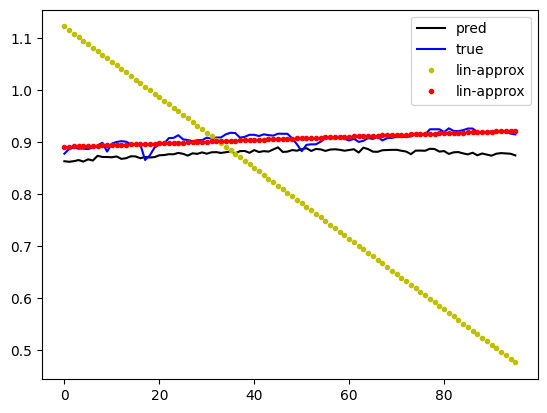

In [85]:
idx = 0
jdx = 4
plt.plot(x0, pred_data[idx, :, jdx], 'k', label='pred')
plt.plot(x0, true_data[idx, :, jdx], 'b', label='true')
plt.plot(x0, resa[idx, :, jdx], 'y.', label='lin-approx')
plt.plot(x0, rest[:, jdx], 'r.', label='lin-approx')
plt.legend()
plt.show()

In [75]:
MAE(rest[:, 0], rest[:,-1])

0.0